[Spark with Jupyter Notebook on MacOS (2.0.0 and higher)](https://medium.com/@roshinijohri/spark-with-jupyter-notebook-on-macos-2-0-0-and-higher-c61b971b5007)
==========================================================================================

#### Run in Terminal:
$\textrm{brew install apache-spark}$

$\textrm{brew info apache-spark}$

$\textrm{export SPARK_HOME='/usr/local/Cellar/apache-spark/2.4.5/libexec/'}$ -> Edit depending on version

$\textrm{pyspark}$

In [1]:
import os
exec(open(os.path.join(os.environ['SPARK_HOME'], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.5
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [2]:
import pyspark
from pyspark.sql.session import SparkSession
spark = SparkSession.builder \
    .appName('spark test') \
    .getOrCreate() \

columns = ['id', 'dogs', 'cats']
vals = [
    (1, 2, 0),
    (2, 0, 1)
]

In [3]:
# Create DataFrame
df = spark.createDataFrame(vals, columns)
df.show()

+---+----+----+
| id|dogs|cats|
+---+----+----+
|  1|   2|   0|
|  2|   0|   1|
+---+----+----+



# Maps

In Spark, maps take data as input and then transform that data with whatever function you put in the map. They are like directions for the data telling how each input should get to the output.

The first code cell creates a SparkContext object. With the SparkContext, you can input a dataset and parallelize the data across a cluster (since you are currently using Spark in local mode on a single machine, technically the dataset isn't distributed yet).

Run the code cell below to instantiate a SparkContext object and then read in the `log_of_songs` list into Spark. 

In [4]:
# The findspark Python module makes it easier to install Spark in local mode on your computer
# This is convenient for practicing Spark syntax locally.
import findspark
findspark.init('/usr/local/Cellar/apache-spark/2.4.5/libexec')

In [5]:
from pyspark import SparkContext

# Shut down the SparkContext
sc.stop()

# Main entry point for Spark functionality; A SparkContext represents the connection to a Spark cluster, 
#   and can be used to create L{RDD} and broadcast variables on that cluster
# Note: master: Cluster URL to connect to (e.g. mesos://host:port, spark://host:port, local[4])
#      appName: a name for your job, to display on the cluster web UI
sc = SparkContext(appName='maps_and_lazy_evaluation_example')
sc

<SparkContext master=local[*] appName=maps_and_lazy_evaluation_example>

In [6]:
# Control our logLevel. This overrides any user-defined log settings.
#   Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN
sc.setLogLevel('INFO')

#### Parallelize the log_of_songs to use with Spark

In [7]:
log_of_songs = [
    'Despacito',
    'Nice for what',
    'No tears left to cry',
    'Despacito',
    'Havana',
    'In my feelings',
    'Nice for what',
    'despacito',
    'All the stars'
]

# Distribute a local Python collection to form an RDD
# Using xrange is recommended if the input represents a range for performance
distributed_song_log = sc.parallelize(log_of_songs)

In [8]:
# Define a function that converts a song title to lowercase
def convert_song_to_lowercase(song):
    return song.lower()

convert_song_to_lowercase('Havana')

'havana'

The following code cells demonstrate how to apply this function using a map step. The map step will go through each song in the list and apply the `convert_song_to_lowercase()` function.

In [9]:
# Return a new RDD by applying a function to each element of this RDD
distributed_song_log.map(convert_song_to_lowercase)

PythonRDD[1] at RDD at PythonRDD.scala:53

You'll notice that this code cell ran quite quickly. This is because of lazy evaluation. Spark does not actually execute the map step unless it needs to.

"RDD" in the output refers to resilient distributed dataset. RDDs are exactly what they say they are: fault-tolerant datasets distributed across a cluster. This is how Spark stores data. 

To get Spark to actually run the map step, you need to use an "action". One available action is the collect method. The `collect()` method takes the results from all of the clusters and "collects" them into a single list on the master node.

In [10]:
# Return a new RDD by applying a function to each element of this RDD
# Return a list that contains all of the elements in this RDD
# Note: This method should only be used if the resulting array is expected to be small, as all the data 
#       is loaded into the driver’s memory
distributed_song_log.map(convert_song_to_lowercase).collect()

['despacito',
 'nice for what',
 'no tears left to cry',
 'despacito',
 'havana',
 'in my feelings',
 'nice for what',
 'despacito',
 'all the stars']

Note that Spark is not changing the original data set: Spark is merely making a copy. You can see this by running `collect()` on the original dataset.

In [11]:
# Return a list that contains all of the elements in this RDD
# Note: This method should only be used if the resulting array is expected to be small, as all the data 
#       is loaded into the driver’s memory
distributed_song_log.collect()

['Despacito',
 'Nice for what',
 'No tears left to cry',
 'Despacito',
 'Havana',
 'In my feelings',
 'Nice for what',
 'despacito',
 'All the stars']

You do not always have to write a custom function for the map step. You can also use anonymous (lambda) functions as well as built-in Python functions like `string.lower()`. 

Anonymous functions are actually a Python feature for writing functional style programs.

In [12]:
# Return a new RDD by applying a function to each element of this RDD
# Return a list that contains all of the elements in this RDD
# Note: This method should only be used if the resulting array is expected to be small, as all the data 
#       is loaded into the driver’s memory
distributed_song_log.map(lambda song: song.lower()).collect()
#distributed_song_log.map(lambda x: x.lower()).collect()

['despacito',
 'nice for what',
 'no tears left to cry',
 'despacito',
 'havana',
 'in my feelings',
 'nice for what',
 'despacito',
 'all the stars']

# Reading and Writing Data with Spark

In [13]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

Since we're using Spark locally we already have both a sparkcontext and a sparksession running. We can update some of the parameters, such our application's name. Let's just call it "Our first Python Spark SQL example".

In [14]:
# Instantiate a Spark session 
# The entry point to programming Spark with the Dataset and DataFrame API
# Note: appName(): sets a name for the application, which will be shown in the Spark web UI
#       getOrCreate(): get or instantiate a SparkContext and register it as a singleton object
spark = SparkSession.builder \
    .appName('Our first Python Spark SQL example') \
    .getOrCreate()

Let's check if the change went through.

In [15]:
# Get all values as a list of key-value pairs
spark.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1592506310635'),
 ('spark.app.name', 'Our first Python Spark SQL example'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '192.168.0.19'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '52013'),
 ('spark.ui.showConsoleProgress', 'true')]

In [16]:
spark

As you can see the app name is exactly how we set it

Let's create our first dataframe from a fairly small sample data set. Througout the course we'll work with a log file data set that describes user interactions with a music streaming service. The records describe events such as logging in to the site, visiting a page, listening to the next song, seeing an ad.

In [17]:
path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/Spark/Udacity_Spark for Big Data/Data Wrangling with Spark/data/sparkify_log_small.json'

# Loads JSON files and returns the results as a :class:`DataFrame`
# Note: path: string represents path to the JSON dataset, or a list of paths, or RDD of Strings storing JSON objects
user_log = spark.read.json(path=path)

In [18]:
# Prints out the schema in the tree format
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [19]:
# Computes basic statistics for numeric and string columns, this include count, mean, stddev, min, and max
#   If no columns are given, this function computes statistics for all numerical or string columns
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [20]:
# Computes basic statistics for numeric and string columns, this include count, mean, stddev, min, and max
#   If no columns are given, this function computes statistics for all numerical or string columns
user_log.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|             8347|
|   mean|249.6486587492506|
| stddev|95.00437130781461|
|    min|          1.12281|
|    max|        1806.8371|
+-------+-----------------+



In [21]:
# Prints the first n rows to the console
# Note: n: Number of rows to show
#       truncate: whether truncate long strings and align cells right
user_log.show(n=1, truncate=True)

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+------

In [22]:
# Returns the first ``num`` rows as a :class:`list` of :class:`Row`
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [23]:
out_path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/Spark/Udacity_Spark for Big Data/Data Wrangling with Spark/data/sparkify_log_small.csv'

# Saves the contents of the :class:`DataFrame` to a data source
# Note: path: the path in a Hadoop supported file system
#       format: the format used to save
#       mode: specifies the behavior of the save operation when data already exists
#             * ``append``: Append contents of this :class:`DataFrame` to existing data.
#             * ``overwrite``: Overwrite existing data.
#             * ``ignore``: Silently ignore this operation if data already exists.
#             * ``error`` or ``errorifexists`` (default case): Throw an exception if data already exists
#       header: uses the first line as names of columns; if None is set, it uses the default value, ``false``
user_log.write.save(path=out_path, format='csv', mode='overwrite', header=True)

In [24]:
# Loads a CSV file and returns the result as a :class:`DataFrame`
# path: string, or list of strings, for input path(s), or RDD of Strings storing CSV rows
# header: uses the first line as names of columns; if None is set, it uses the default value, ``false``
user_log_2 = spark.read.csv(path=out_path, header=True)

In [25]:
# Prints out the schema in the tree format
user_log_2.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [26]:
# Returns the first ``num`` rows as a :class:`list` of :class:`Row`
user_log_2.take(2)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession='112', lastName='Matthews', length='232.93342', level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration='1509380319284', sessionId='5132', song='Christmas Tears Will Fall', status='200', ts='1513720872284', userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession='7', lastName='Chase', length='195.23873', level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration='1512718541284', sessionId='5027', song='Cheryl Tweedy', status='200', ts='1513720878284', userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000')]

In [27]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
user_log_2.select('userID').show()

+------+
|userID|
+------+
|  1046|
|  1000|
|  2219|
|  2373|
|  1747|
|  1747|
|  1162|
|  1061|
|   748|
|   597|
|  1806|
|   748|
|  1176|
|  2164|
|  2146|
|  2219|
|  1176|
|  2904|
|   597|
|   226|
+------+
only showing top 20 rows



In [28]:
# Returns the first ``num`` rows as a :class:`list` of :class:`Row`
user_log_2.take(1)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession='112', lastName='Matthews', length='232.93342', level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration='1509380319284', sessionId='5132', song='Christmas Tears Will Fall', status='200', ts='1513720872284', userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')]

# Data Wrangling with Spark DataFrames

Helpful resources:
http://spark.apache.org/docs/latest/api/python/pyspark.sql.html

In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan, count, when, col, sort_array, avg
from pyspark.sql.functions import asc, desc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [30]:
# Instantiate a Spark session 
# The entry point to programming Spark with the Dataset and DataFrame API
# Note: appName(): sets a name for the application, which will be shown in the Spark web UI
#       getOrCreate(): get or instantiate a SparkContext and register it as a singleton object
spark = SparkSession.builder \
    .appName('Data Wrangling with Spark DataFrame') \
    .getOrCreate()

In [31]:
path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/Spark/Udacity_Spark for Big Data/Data Wrangling with Spark/data/sparkify_log_small.json'

# Loads JSON files and returns the results as a :class:`DataFrame`
# Note: path: string represents path to the JSON dataset, or a list of paths, or RDD of Strings storing JSON objects
user_log = spark.read.json(path=path)

### Data Exploration 

In [32]:
# Prints out the schema in the tree format
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [33]:
# Returns the first ``num`` rows as a :class:`list` of :class:`Row`
user_log.take(5)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046'),
 Row(artist='Lily Allen', auth='Logged In', firstName='Elizabeth', gender='F', itemInSession=7, lastName='Chase', length=195.23873, level='free', location='Shreveport-Bossier City, LA', method='PUT', page='NextSong', registration=1512718541284, sessionId=5027, song='Cheryl Tweedy', status=200, ts=1513720878284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1000'),
 Row(artist='Cobra Starship Featuring Leighton Meester', auth='Logged In', firstNa

In [34]:
# Computes basic statistics for numeric and string columns, this include count, mean, stddev, min, and max
#   If no columns are given, this function computes statistics for all numerical or string columns
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|           length|level|    location|method|   page|        registration|         sessionId|    song|           status|                 ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+-----------------+-----+------------+------+-------+--------------------+------------------+--------+-----------------+-------------------+--------------------+------------------+
|  count|             8347|     10000|     9664|  9664|             10000|    9664|             8347|10000|        9664| 10000|  10000|                9664|             10000|    8347|            10000|         

In [35]:
# Computes basic statistics for numeric and string columns, this include count, mean, stddev, min, and max
#   If no columns are given, this function computes statistics for all numerical or string columns
user_log.describe('artist').show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|             8347|
|   mean|            461.0|
| stddev|            300.0|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+



In [36]:
# Computes basic statistics for numeric and string columns, this include count, mean, stddev, min, and max
#   If no columns are given, this function computes statistics for all numerical or string columns
user_log.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|             10000|
|   mean|         4436.7511|
| stddev|2043.1281541827561|
|    min|                 9|
|    max|              7144|
+-------+------------------+



In [37]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(user_log.count(), len(user_log.columns)))

Rows: 10000, Cols: 18


In [38]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
# Return a new DataFrame with duplicate rows removed, optionally only considering certain columns
# Returns a new DataFrame sorted by the specified column(s)
# Note: cols: list of Column or column names to sort by.
#       ascending: boolean or list of boolean (default True); sort ascending vs. descending; specify list for 
#                  multiple sort orders; if a list is specified, length of the list must equal length of the cols
user_log.select('page').dropDuplicates().sort('page').show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [39]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
# Filters rows using the given condition
user_log.select(['userId', 'firstname', 'page', 'song']).where(user_log.userId == '1046').collect()

[Row(userId='1046', firstname='Kenneth', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Father And Son'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='No. 5'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Seventeen'),
 Row(userId='1046', firstname='Kenneth', page='Home', song=None),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='War on war'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Killermont Street'),
 Row(userId='1046', firstname='Kenneth', page='NextSong', song='Black & Blue'),
 Row(userId='1046', firstname='Kenneth', page='Logout', song=None),
 Row(userId='1046', firstname='Kenneth'

### Calculating Statistics by Hour

In [40]:
# Create a user defined function (UDF)
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [41]:
# Returns a new :class:`DataFrame` by adding a column or replacing the existing column that has the same name
user_log = user_log.withColumn('hour', get_hour(user_log.ts))

In [42]:
# Returns the first ``n`` rows
user_log.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14')

In [43]:
# Filters rows using the given condition
# Groups the DataFrame using the specified columns, so we can run aggregation on them
# Returns the number of rows in this DataFrame
# Returns a new DataFrame sorted by the specified column(s)
# Note: cols: list of Column or column names to sort by.
#       ascending: boolean or list of boolean (default True); sort ascending vs. descending; specify list for 
#                  multiple sort orders; if a list is specified, length of the list must equal length of the cols
songs_in_hour = user_log.filter(user_log.page == 'NextSong').groupby(user_log.hour).count().orderBy(user_log.hour.cast('float'))

In [44]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  375|
|   1|  249|
|   2|  216|
|   3|  228|
|   4|  251|
|   5|  339|
|   6|  462|
|   7|  479|
|   8|  484|
|   9|  430|
|  10|  362|
|  11|  295|
|  12|  257|
|  13|  248|
|  14|  369|
|  15|  375|
|  16|  456|
|  17|  454|
|  18|  382|
|  19|  302|
+----+-----+
only showing top 20 rows



In [45]:
# Returns the contents of this :class:`DataFrame` as Pandas ``pandas.DataFrame``
songs_in_hour_pd = songs_in_hour.toPandas()

# Convert argument to a numeric type
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

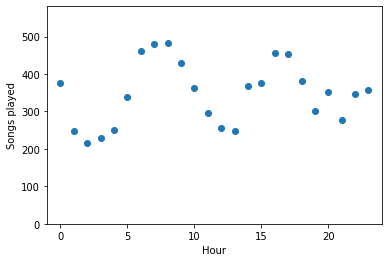

In [46]:
# Create a scatter plot
plt.scatter(songs_in_hour_pd['hour'], songs_in_hour_pd['count'])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd['count']))
plt.xlabel('Hour')
plt.ylabel('Songs played');

### Drop Rows with Missing Values

As you'll see, it turns out there are no missing values in the userID or session columns. But there are userID values that are empty strings.

In [47]:
# Returns a new :class:`DataFrame` omitting rows with null values
# Note: how: if 'any', drop a row if it contains any nulls; if 'all', drop a row only if all its values are null
#       subset: optional list of column names to consider
user_log_valid = user_log.dropna(how='any', subset=['userId', 'sessionId'])

In [48]:
# Returns the number of rows in this DataFrame
user_log_valid.count()

10000

In [49]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
# Return a new DataFrame with duplicate rows removed, optionally only considering certain columns
# Returns a new DataFrame sorted by the specified column(s)
# Note: cols: list of Column or column names to sort by.
#       ascending: boolean or list of boolean (default True); sort ascending vs. descending; specify list for 
#                  multiple sort orders; if a list is specified, length of the list must equal length of the cols
user_log.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|  1000|
|  1003|
|  1005|
|  1006|
|  1017|
|  1019|
|  1020|
|  1022|
|  1025|
|  1030|
|  1035|
|  1037|
|   104|
|  1040|
|  1042|
|  1043|
|  1046|
+------+
only showing top 20 rows



In [50]:
# Filters rows using the given condition
user_log_valid = user_log_valid.filter(user_log_valid['userId'] != '')

# Returns the number of rows in this DataFrame
user_log_valid.count()

9664

In [51]:
# Filters rows using the given condition
user_log_valid = user_log_valid.where(user_log_valid.userId != '')

# Returns the number of rows in this DataFrame
user_log_valid.count()

9664

### Users Downgrade Their Accounts

Find when users downgrade their accounts and then flag those log entries. Then use a window function and cumulative sum to distinguish each user's data as either pre or post downgrade events.

In [52]:
# Filters rows using the given condition
user_log_valid.filter(user_log_valid.page == 'Submit Downgrade').show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|    Kelly|     F|           24|  Newton|  null| paid|Houston-The Woodl...|   PUT|Submit Downgrade|1513283366284|     5931|null|   307|1513768454284|Mozilla/5.0 (Wind...|  1138|   3|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+


In [53]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
# Filters rows using the given condition
user_log.select(['userId', 'firstname', 'page', 'level', 'song']).where(user_log.userId == '1138').show(truncate=False)

+------+---------+--------+-----+---------------------------------------+
|userId|firstname|page    |level|song                                   |
+------+---------+--------+-----+---------------------------------------+
|1138  |Kelly    |Home    |paid |null                                   |
|1138  |Kelly    |NextSong|paid |Everybody Everybody                    |
|1138  |Kelly    |NextSong|paid |Gears                                  |
|1138  |Kelly    |NextSong|paid |Use Somebody                           |
|1138  |Kelly    |NextSong|paid |Love Of My Life (1993 Digital Remaster)|
|1138  |Kelly    |NextSong|paid |Down In The Valley Woe                 |
|1138  |Kelly    |NextSong|paid |Treat Her Like A Lady                  |
|1138  |Kelly    |NextSong|paid |Everybody Thinks You're An Angel       |
|1138  |Kelly    |NextSong|paid |Fourteen Wives                         |
|1138  |Kelly    |NextSong|paid |Love On The Rocks                      |
|1138  |Kelly    |NextSong|paid |Break

In [54]:
user_log.select(['userId', 'firstname', 'page', 'level', 'song']).where(user_log.userId == '1138').collect()

[Row(userId='1138', firstname='Kelly', page='Home', level='paid', song=None),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Everybody Everybody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Gears'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Use Somebody'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love Of My Life (1993 Digital Remaster)'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Down In The Valley Woe'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Treat Her Like A Lady'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song="Everybody Thinks You're An Angel"),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Fourteen Wives'),
 Row(userId='1138', firstname='Kelly', page='NextSong', level='paid', song='Love On The Rocks'),
 Row(userId='1138', f

In [55]:
# Create a user defined function (UDF)
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

In [56]:
# Returns a new :class:`DataFrame` by adding a column or replacing the existing column that has the same name
user_log_valid = user_log_valid.withColumn('downgraded', flag_downgrade_event('page'))

In [57]:
# Returns the first ``n`` rows
user_log_valid.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14', downgraded=0)

In [58]:
from pyspark.sql import Window

In [59]:
# Creates a :class:`WindowSpec` with the partitioning defined
windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

In [60]:
# Returns a new :class:`DataFrame` by adding a column or replacing the existing column that has the same name
user_log_valid = user_log_valid.withColumn('phase', Fsum('downgraded').over(windowval))

In [61]:
# Projects a set of expressions and returns a new :class:`DataFrame
# Note: cols: list of column names (string) or expressions (:class:`Column`); if one of the column names is '*', 
#             that column is expanded to include all columns in the current :class:`DataFrame`
# Filters rows using the given condition
# Returns a new DataFrame sorted by the specified column(s)
# Note: cols: list of Column or column names to sort by.
#       ascending: boolean or list of boolean (default True); sort ascending vs. descending; specify list for 
#                  multiple sort orders; if a list is specified, length of the list must equal length of the cols
user_log_valid.select(['userId', 'firstname', 'ts', 'page', 'level', 'phase']).where(user_log.userId == '1138').sort('ts').collect()

[Row(userId='1138', firstname='Kelly', ts=1513729066284, page='Home', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729066284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729313284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729552284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513729783284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730001284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730263284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730518284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513730768284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firstname='Kelly', ts=1513731182284, page='NextSong', level='paid', phase=1),
 Row(userId='1138', firs

### Question 1

Which page did user id '' (empty string) NOT visit?

In [62]:
user_log.select(['userId', 'page',]).dropDuplicates().sort('page').where(user_log.userId == '').collect()

[Row(userId='', page='About'),
 Row(userId='', page='Help'),
 Row(userId='', page='Home'),
 Row(userId='', page='Login')]

In [63]:
# Filter for users with blank user id
blank_pages = user_log.where(user_log.userId == '') \
    .select(col('page') \
    .alias('blank_pages')) \
    .dropDuplicates() \
    .sort('blank_pages')
blank_pages.collect()

[Row(blank_pages='About'),
 Row(blank_pages='Help'),
 Row(blank_pages='Home'),
 Row(blank_pages='Login')]

In [64]:
# Get a list of possible pages that could be visited
all_pages = user_log.select('page').dropDuplicates().sort('page')
all_pages.show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



In [65]:
# Find values in all_pages that are not in blank_pages
# These are the pages that the blank user did not go to
for row in set(all_pages.collect()) - set(blank_pages.collect()):
    print(row.page)

NextSong
Upgrade
Save Settings
Error
Logout
Downgrade
Settings
Submit Upgrade
Submit Downgrade


### Question 2

What type of user does the empty string userId most likely refer to?

Perhaps it represents users who have not signed up yet or who are signed out and are about to log in.

### Question 3

How many female users do we have in the data set?

In [66]:
# All female user records
user_log.select('userId', 'gender') \
    .where(user_log.gender=='F') \
    .count()

3820

In [67]:
# Unique female user records
user_log.select('userId', 'gender') \
    .dropDuplicates() \
    .where(user_log.gender=='F') \
    .count()

462

### Question 4

How many songs were played from the most played artist?

In [68]:
user_log.where(user_log.page == "NextSong").groupby(user_log.artist).count().sort('count', ascending=False).show(1)

+--------+-----+
|  artist|count|
+--------+-----+
|Coldplay|   83|
+--------+-----+
only showing top 1 row



In [69]:
user_log.select('artist') \
    .where(user_log.page == 'NextSong') \
    .groupby('artist') \
    .agg({'artist':'count'}) \
    .withColumnRenamed('count(artist)', 'artist_count') \
    .sort(desc('artist_count')) \
    .show(1)

+--------+------------+
|  artist|artist_count|
+--------+------------+
|Coldplay|          83|
+--------+------------+
only showing top 1 row



### Question 5

How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [70]:
function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = user_log.where((user_log.page == 'NextSong') | (user_log.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.where((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 6.898347107438017|
+------------------+



# Data Wrangling with Spark SQL

Helpful resources:
http://spark.apache.org/docs/latest/api/python/pyspark.sql.html

In [71]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import asc, desc
from pyspark.sql.functions import sum as Fsum

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
# Instantiate a Spark session 
# The entry point to programming Spark with the Dataset and DataFrame API
# Note: appName(): sets a name for the application, which will be shown in the Spark web UI
#       getOrCreate(): get or instantiate a SparkContext and register it as a singleton object
spark = SparkSession.builder \
    .appName('Data wrangling with Spark SQL') \
    .getOrCreate()

In [73]:
path = '/Users/yangweichle/Documents/Employment/TRAINING/DATA SCIENCE/Spark/Udacity_Spark for Big Data/Data Wrangling with Spark/data/sparkify_log_small.json'

# Loads JSON files and returns the results as a :class:`DataFrame`
# Note: path: string represents path to the JSON dataset, or a list of paths, or RDD of Strings storing JSON objects
user_log = spark.read.json(path=path)

In [74]:
# Returns the first ``num`` rows as a :class:`list` of :class:`Row`
user_log.take(1)

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046')]

In [75]:
# Prints out the schema in the tree format
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Create a View And Run Queries

The code below creates a temporary view against which you can run SQL queries.

In [76]:
# Creates or replaces a local temporary view with this :class:`DataFrame`
user_log.createOrReplaceTempView('user_log_view')

In [77]:
spark.sql('SELECT * FROM user_log_view LIMIT 2').show()

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
|   Lily Allen|Logged In|Elizabeth|     F|            7|   Chase|195.23873| free|Shreveport-Bossie...|   PUT|NextSong|1512718541284|     5027|      

In [78]:
spark.sql('''
          SELECT * 
          FROM user_log_view 
          LIMIT 2
          '''
          ).show()

+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|Showaddywaddy|Logged In|  Kenneth|     M|          112|Matthews|232.93342| paid|Charlotte-Concord...|   PUT|NextSong|1509380319284|     5132|Christmas Tears W...|   200|1513720872284|"Mozilla/5.0 (Win...|  1046|
|   Lily Allen|Logged In|Elizabeth|     F|            7|   Chase|195.23873| free|Shreveport-Bossie...|   PUT|NextSong|1512718541284|     5027|      

In [79]:
spark.sql('''
          SELECT COUNT(*) 
          FROM user_log_view 
          '''
          ).show()

+--------+
|count(1)|
+--------+
|   10000|
+--------+



In [80]:
spark.sql('''
          SELECT userID,
                 firstname,
                 page,
                 song
          FROM user_log_view 
          WHERE userID == '1046'
          '''
          ).show(100, truncate=False)

+------+---------+--------+----------------------------------------------------+
|userID|firstname|page    |song                                                |
+------+---------+--------+----------------------------------------------------+
|1046  |Kenneth  |NextSong|Christmas Tears Will Fall                           |
|1046  |Kenneth  |NextSong|Be Wary Of A Woman                                  |
|1046  |Kenneth  |NextSong|Public Enemy No.1                                   |
|1046  |Kenneth  |NextSong|Reign Of The Tyrants                                |
|1046  |Kenneth  |NextSong|Father And Son                                      |
|1046  |Kenneth  |NextSong|No. 5                                               |
|1046  |Kenneth  |NextSong|Seventeen                                           |
|1046  |Kenneth  |Home    |null                                                |
|1046  |Kenneth  |NextSong|War on war                                          |
|1046  |Kenneth  |NextSong|K

In [81]:
spark.sql('''
          SELECT DISTINCT page
          FROM user_log_view 
          ORDER BY page ASC
          '''
          ).show()

+----------------+
|            page|
+----------------+
|           About|
|       Downgrade|
|           Error|
|            Help|
|            Home|
|           Login|
|          Logout|
|        NextSong|
|   Save Settings|
|        Settings|
|Submit Downgrade|
|  Submit Upgrade|
|         Upgrade|
+----------------+



### User Defined Functions

In [82]:
# Register a Python function (including lambda function) or a user-defined function as a SQL function
spark.udf.register('get_hour', lambda x: int(datetime.datetime.fromtimestamp(x / 1000.0).hour))

<function __main__.<lambda>(x)>

In [83]:
spark.sql('''
          SELECT *,
                 get_hour(ts) AS hour
          FROM user_log_view
          LIMIT 1
          '''
          ).collect()

[Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='14')]

In [84]:
songs_in_hour = spark.sql('''
          SELECT get_hour(ts) AS hour,
                 COUNT(*) AS plays_per_hour
          FROM user_log_view
          WHERE page = "NextSong"
          GROUP BY hour
          ORDER BY CAST(hour AS int) ASC
          '''
          )

In [85]:
songs_in_hour.show(n=25)

+----+--------------+
|hour|plays_per_hour|
+----+--------------+
|   0|           375|
|   1|           249|
|   2|           216|
|   3|           228|
|   4|           251|
|   5|           339|
|   6|           462|
|   7|           479|
|   8|           484|
|   9|           430|
|  10|           362|
|  11|           295|
|  12|           257|
|  13|           248|
|  14|           369|
|  15|           375|
|  16|           456|
|  17|           454|
|  18|           382|
|  19|           302|
|  20|           352|
|  21|           276|
|  22|           348|
|  23|           358|
+----+--------------+



### Converting Results to Pandas

In [86]:
# Returns the contents of this :class:`DataFrame` as Pandas ``pandas.DataFrame``
songs_in_hour_pd = songs_in_hour.toPandas()

In [87]:
print(songs_in_hour_pd)

   hour  plays_per_hour
0     0             375
1     1             249
2     2             216
3     3             228
4     4             251
5     5             339
6     6             462
7     7             479
8     8             484
9     9             430
10   10             362
11   11             295
12   12             257
13   13             248
14   14             369
15   15             375
16   16             456
17   17             454
18   18             382
19   19             302
20   20             352
21   21             276
22   22             348
23   23             358


### Question 1

Which page did user id '' (empty string) NOT visit?

In [88]:
# SELECT distinct pages for the blank user and distinct pages for all users
# Right join the results to find pages that blank visitor did not visit
spark.sql("""
          SELECT *
          FROM (SELECT DISTINCT page
                FROM user_log_view
                WHERE userID = '') AS user_pages
          RIGHT JOIN (SELECT DISTINCT page
                      FROM user_log_view) AS all_pages
          ON user_pages.page = all_pages.page
          WHERE user_pages.page IS NULL
          """).show()

+----+----------------+
|page|            page|
+----+----------------+
|null|Submit Downgrade|
|null|       Downgrade|
|null|          Logout|
|null|   Save Settings|
|null|        Settings|
|null|        NextSong|
|null|         Upgrade|
|null|           Error|
|null|  Submit Upgrade|
+----+----------------+



### Question 2

Why might you prefer to use SQL over DataFrames? Why might you prefer DataFrames over SQL?

Both Spark SQL and Spark DataFrames are part of the Spark SQL library. Hence, they both use the Spark SQL Catalyst Optimizer to optimize queries. 

You might prefer SQL over DataFrames because the syntax is clearer especially for teams already experienced in SQL.

Spark DataFrames give you more control. You can break down your queries into smaller steps, which can make debugging easier. You can also [cache](https://unraveldata.com/to-cache-or-not-to-cache/) intermediate results or [repartition](https://hackernoon.com/managing-spark-partitions-with-coalesce-and-repartition-4050c57ad5c4) intermediate results.

### Question 3

How many female users do we have in the data set?

In [89]:
spark.sql("""
          SELECT COUNT(DISTINCT userID)
          FROM user_log_view
          WHERE gender = 'F'
          """).show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   462|
+----------------------+



### Question 4

How many songs were played from the most played artist?

In [90]:
# Here is one solution
spark.sql("""
          SELECT artist,
                 COUNT(artist) AS plays
          FROM user_log_view
          GROUP BY Artist
          ORDER BY plays DESC
          LIMIT 1
          """).show()

+--------+-----+
|  artist|plays|
+--------+-----+
|Coldplay|   83|
+--------+-----+



In [91]:
# Here is an alternative solution
# Get the artist play counts
play_counts = \
spark.sql("""
          SELECT artist,
                 COUNT(artist) AS plays
          FROM user_log_view
          GROUP BY artist
          """)

# save the results in a new view
play_counts.createOrReplaceTempView('artist_counts')

# use a self join to find where the max play equals the count value
spark.sql("""
          SELECT a2.artist, a2.plays
          FROM (SELECT max(plays) AS max_plays
                FROM artist_counts) AS a1
          INNER JOIN artist_counts AS a2
          ON a1.max_plays = a2.plays
          """).show()

+--------+-----+
|  artist|plays|
+--------+-----+
|Coldplay|   83|
+--------+-----+



### Question 5

How many songs do users listen to on average between visiting our home page? Please round your answer to the closest integer.

In [92]:
# SELECT CASE WHEN 1 > 0 THEN 1 WHEN 2 > 0 THEN 2.0 ELSE 1.2 END;
is_home = \
spark.sql("""
          SELECT userID,
                 page,
                 ts,
                 CASE WHEN page = 'Home' THEN 1
                      ELSE 0 END AS is_home
          FROM user_log_view
          WHERE (page = 'NextSong') OR (page = 'Home')
          """)

# keep the results in a new view
is_home.createOrReplaceTempView('is_home_view')

# find the cumulative sum over the is_home column
cumulative_sum = \
spark.sql("""
          SELECT *,
                 SUM(is_home) OVER (PARTITION BY userID ORDER BY ts DESC ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS period
          FROM is_home_view
          """)

# keep the results in a view
cumulative_sum.createOrReplaceTempView('period_view')

# find the average count for NextSong
spark.sql("""
          SELECT AVG(count_results)
          FROM (SELECT COUNT(*) AS count_results
                FROM period_view
                GROUP BY userID,
                         period,
                         page
                HAVING page = 'NextSong') AS counts
          """).show()

+------------------+
|avg(count_results)|
+------------------+
| 6.898347107438017|
+------------------+

